# Imports

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from datetime import datetime
import re
import warnings
warnings.filterwarnings('ignore')

In [56]:
df = pd.read_csv('dataset.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2237 entries, 0 to 2236
Data columns (total 25 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   ID                         2237 non-null   int64 
 1    Ano_Nascimento            2237 non-null   int64 
 2    Educacao                  2237 non-null   object
 3    Estado_Civil              2237 non-null   object
 4    Renda                     2213 non-null   object
 5    Criancas_Em_Casa          2237 non-null   int64 
 6    Adolescentes_Em_Casa      2237 non-null   int64 
 7    Data_Cadastro_Cliente     2237 non-null   object
 8    Gasto_Vinhos              2237 non-null   int64 
 9    Gasto_Frutas              2237 non-null   int64 
 10   Gasto_Carnes              2237 non-null   int64 
 11   Gasto_Peixes              2237 non-null   int64 
 12   Gasto_Doces               2237 non-null   int64 
 13   Gasto_Outros              2237 non-null   int64 
 14   Num_Com

In [57]:
df.columns = df.columns.str.lower().str.strip()
df.head()

,id,ano_nascimento,educacao,estado_civil,renda,criancas_em_casa,adolescentes_em_casa,data_cadastro_cliente,gasto_vinhos,gasto_frutas,...,num_compras_web,num_compras_catalogo,num_compras_loja,num_visitas_web_mes,aceitou_campanha_1,aceitou_campanha_2,aceitou_campanha_3,aceitou_campanha_4,aceitou_campanha_5,aceitou_campanha_6
0,9970,1977,Graduação,Casado,"$55,375.00",0,1,10/17/13,42,11,...,1,1,6,2,0,0,0,0,0,0
1,4002,1960,PhD,Casado,"$77,037.00",0,1,10/13/13,463,96,...,7,7,12,3,0,0,0,0,0,0
2,10914,1970,Graduação,Solteiro,"$24,163.00",1,1,2010-12-13,4,1,...,1,0,3,4,0,0,0,0,0,0
3,7279,1969,PhD,Casado,"$69,476.00",0,0,9/30/13,260,86,...,4,6,4,2,0,0,0,0,0,0
4,10582,1979,Graduação,Casado,"$72,063.00",0,1,2007-03-13,180,32,...,5,2,12,2,0,0,0,0,0,0


In [58]:
# tratando a renda
df['renda'] = df['renda'].str.replace('$','')\
    .str.replace(',','').astype(float)

In [59]:
# tratando a data
df['data_cadastro_cliente'] = pd.to_datetime(df['data_cadastro_cliente'])

In [60]:
# checando info novamente
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2237 entries, 0 to 2236
Data columns (total 25 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   id                        2237 non-null   int64         
 1   ano_nascimento            2237 non-null   int64         
 2   educacao                  2237 non-null   object        
 3   estado_civil              2237 non-null   object        
 4   renda                     2213 non-null   float64       
 5   criancas_em_casa          2237 non-null   int64         
 6   adolescentes_em_casa      2237 non-null   int64         
 7   data_cadastro_cliente     2237 non-null   datetime64[ns]
 8   gasto_vinhos              2237 non-null   int64         
 9   gasto_frutas              2237 non-null   int64         
 10  gasto_carnes              2237 non-null   int64         
 11  gasto_peixes              2237 non-null   int64         
 12  gasto_doces         

In [61]:
# verificando valores ausentes
valores_ausentes = df.isnull().sum()
valores_ausentes

id                           0
ano_nascimento               0
educacao                     0
estado_civil                 0
renda                       24
criancas_em_casa             0
adolescentes_em_casa         0
data_cadastro_cliente        0
gasto_vinhos                 0
gasto_frutas                 0
gasto_carnes                 0
gasto_peixes                 0
gasto_doces                  0
gasto_outros                 0
num_compras_promocionais     0
num_compras_web              0
num_compras_catalogo         0
num_compras_loja             0
num_visitas_web_mes          0
aceitou_campanha_1           0
aceitou_campanha_2           0
aceitou_campanha_3           0
aceitou_campanha_4           0
aceitou_campanha_5           0
aceitou_campanha_6           0
dtype: int64

In [62]:
valores_ausentes.loc[valores_ausentes > 0]

renda    24
dtype: int64

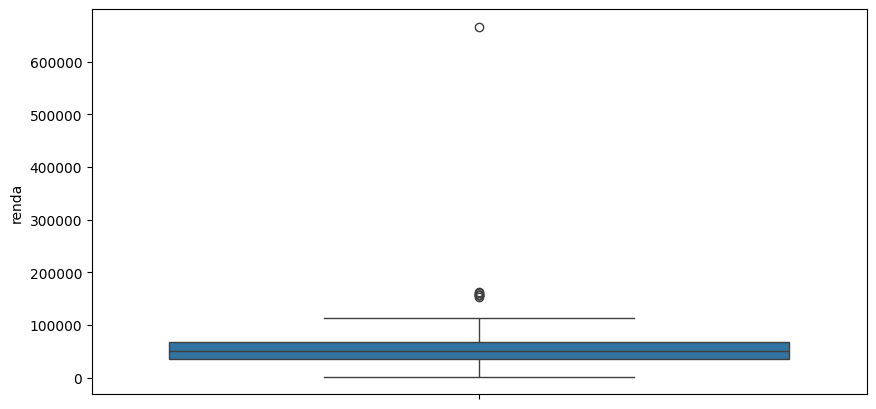

In [63]:
# verificando outliers para tratar valores ausentes
plt.figure(figsize = (10,5))
sns.boxplot(df, y = 'renda')
plt.show()

In [64]:
# Calculando IQR para a coluna renda

def remove_outliers(data, var):
    Q1 = data[var].quantile(0.25)
    Q3 = data[var].quantile(0.75)
    IQR = Q3 - Q1

    lower_limit = Q1 - 1.5 * IQR
    upper_limit = Q3 + 1.5 * IQR

    df_no_outliers = data[(data[var] >= lower_limit) & (data[var] <= upper_limit)]
    outliers = data[(data[var] < lower_limit) | (data[var] > upper_limit)]
    
    return df_no_outliers, outliers

Text(0.5, 1.0, 'Distribuição de Renda')

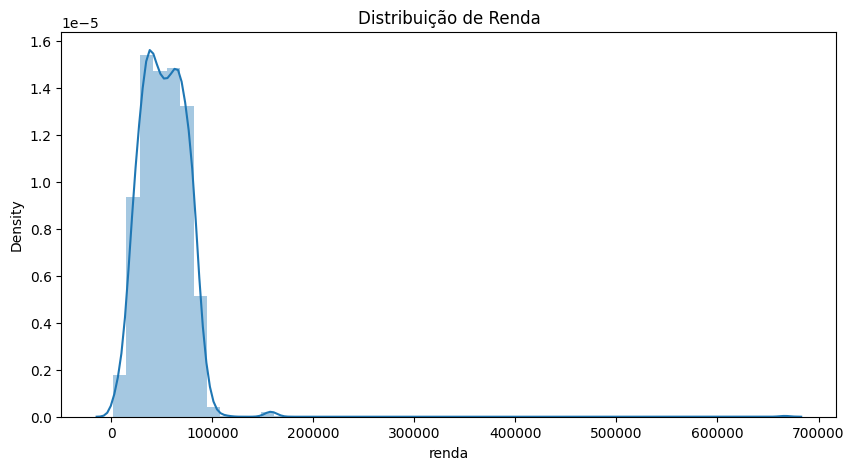

In [65]:
plt.figure(figsize = (10,5))
sns.distplot(df['renda'])
plt.title('Distribuição de Renda')

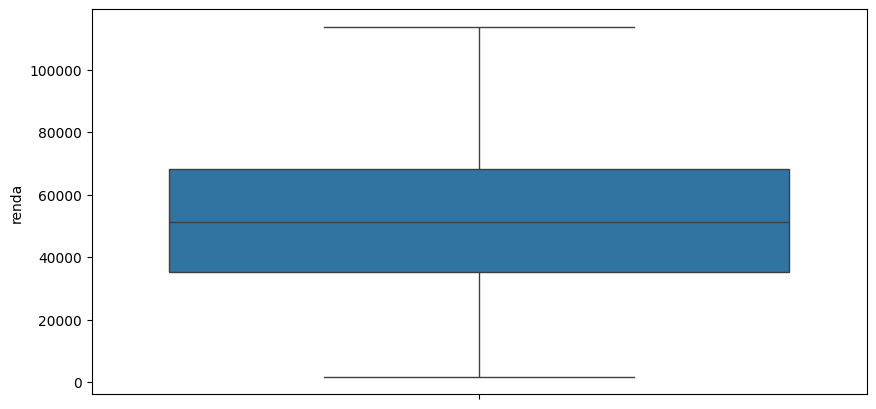

In [66]:
# removendo os outliers
df_no_outliers, outliers = remove_outliers(df, 'renda')

# verificando outliers para tratar valores ausentes
plt.figure(figsize = (10,5))
sns.boxplot(df_no_outliers['renda'])
plt.show()

Text(0.5, 1.0, 'Distribuição de Renda')

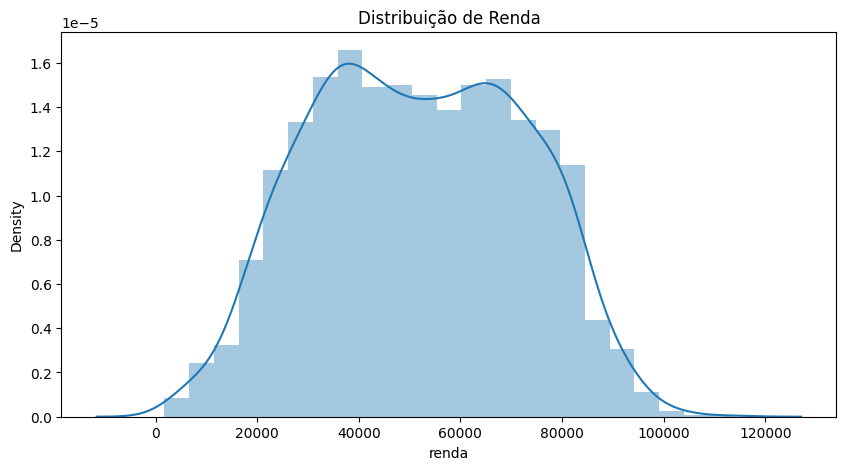

In [67]:
plt.figure(figsize = (10,5))
sns.distplot(df_no_outliers['renda'])
plt.title('Distribuição de Renda')

In [68]:
# Imputando dados para análise exploratoria, APENAS PARA ANALISE EXPLORATORIA

scaler = StandardScaler()
data_scaled = scaler.fit_transform(df_no_outliers[['renda']])

# Cria o KNN Imputer
imputer = KNNImputer(n_neighbors= 5)

# Imputa os valores ausentes
data_imputed = imputer.fit_transform(data_scaled)

3 # Converte novamente para a escala original
df_no_outliers['renda'] = scaler.inverse_transform(data_imputed)

# Total de valores ausentes
print(f'Total de valores ausentes: {df_no_outliers.isnull().sum().sum()}')

Total de valores ausentes: 0


In [69]:
df_plot = df_no_outliers.select_dtypes('number')\
    .loc[:, ~ df_no_outliers.select_dtypes('number').columns.str.contains('aceitou')]\
        .drop('id', axis = 1)

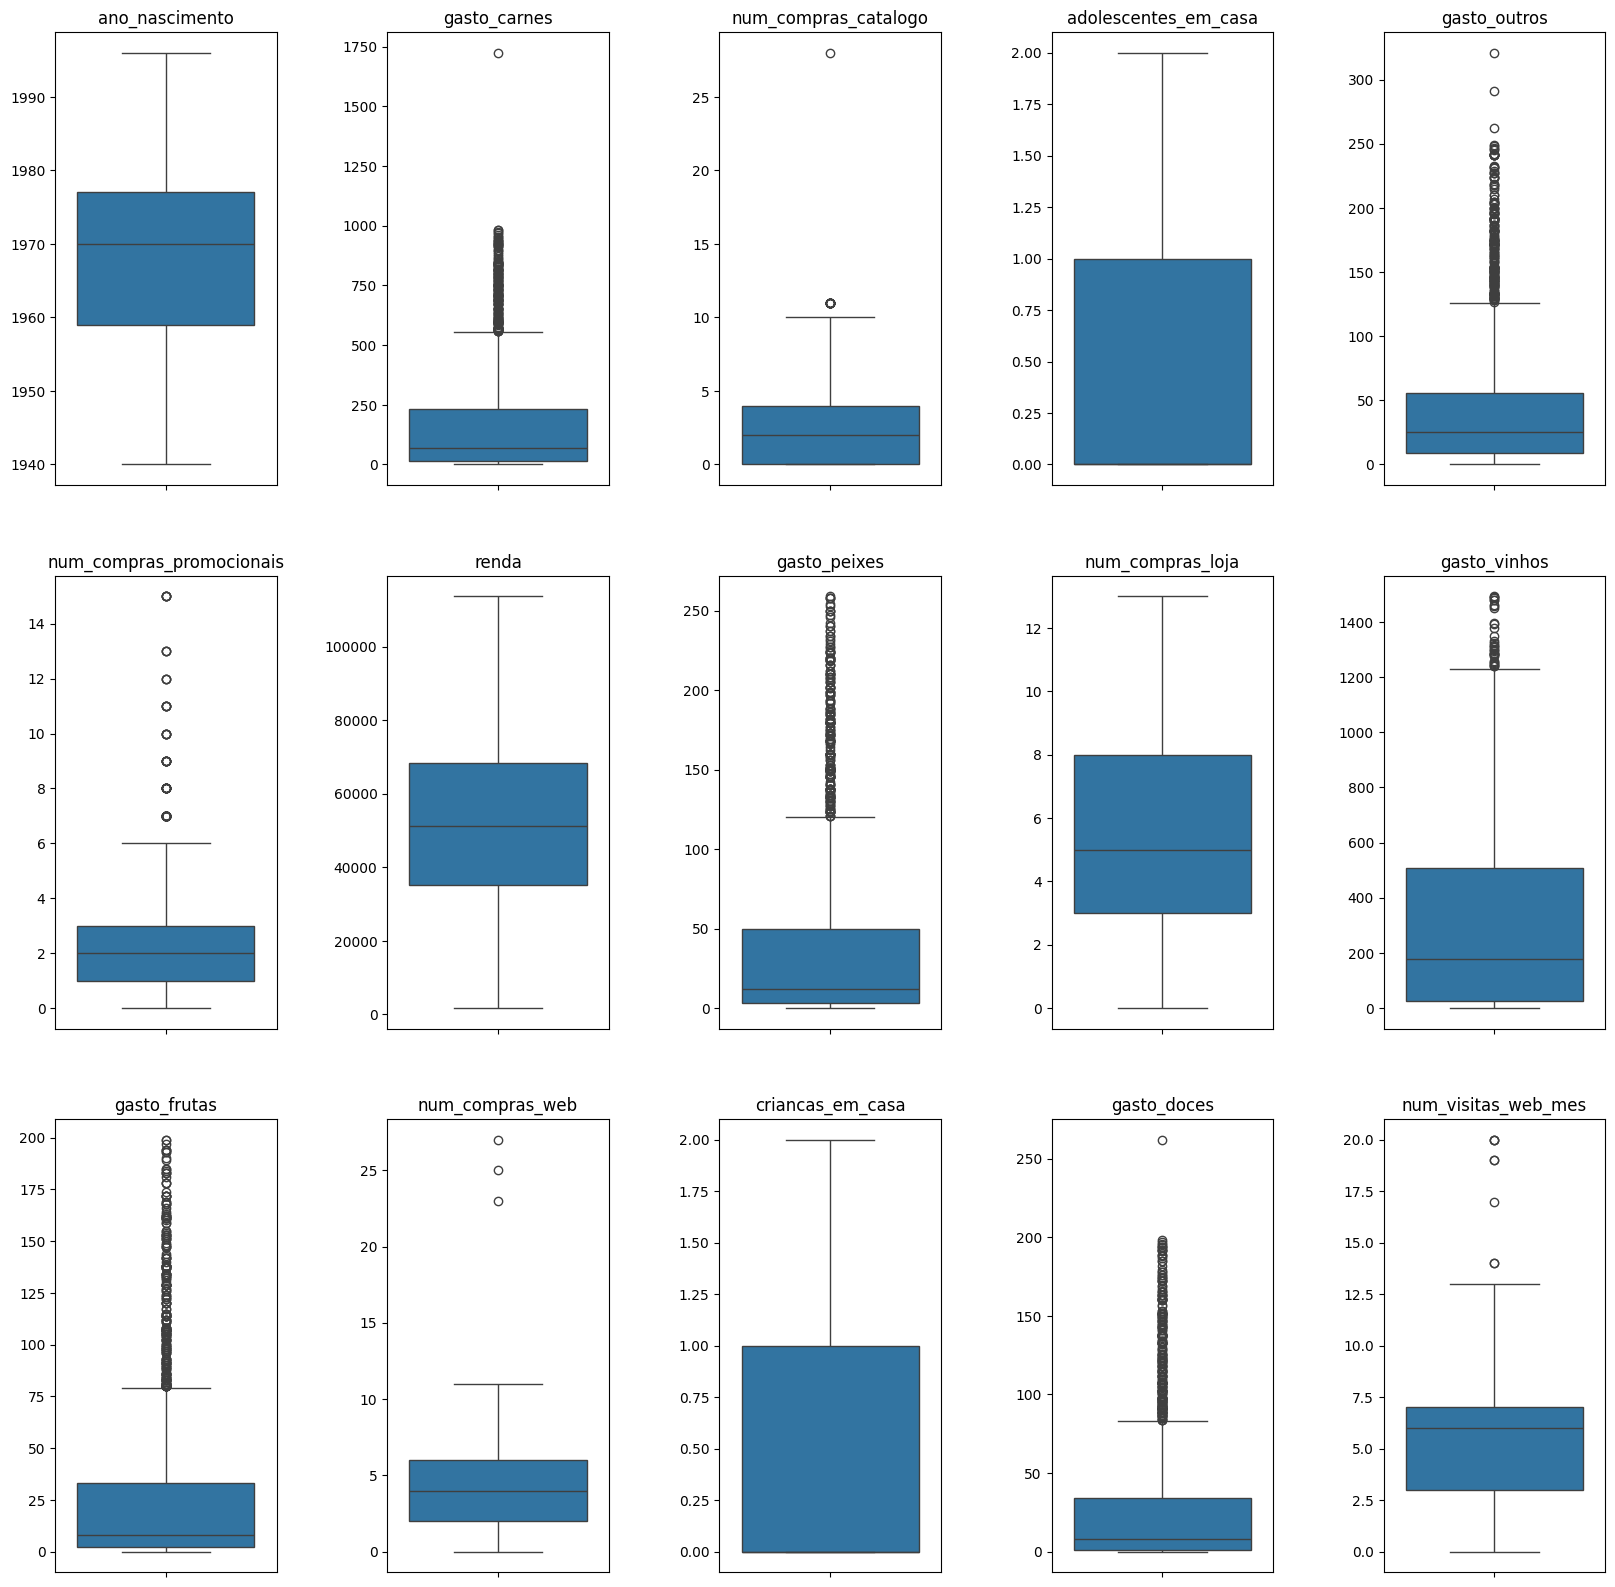

In [70]:
fig, ax = plt.subplots(ncols= 5, nrows=3, figsize = (20,20))

for i, var in enumerate(df_plot.columns):
    row_index = i%3
    col_index = i%5
    sns.boxplot(df_plot, y = var, ax = ax[row_index, col_index])
    ax[row_index, col_index].set_ylabel('')
    ax[row_index, col_index].set_title(var)
    plt.subplots_adjust(wspace = 0.5)

# Feature Engineering

In [71]:
# Criando coluna de idade
df_no_outliers['idade'] = datetime.now().year - df_no_outliers['ano_nascimento']

In [72]:
# Criando coluna de "dias como cliente" e convertendo o tipo de dado
df_no_outliers['dias_como_cliente'] = \
    (df_no_outliers['data_cadastro_cliente'].max() - df_no_outliers['data_cadastro_cliente']).dt.days

In [73]:
df_no_outliers.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2205 entries, 0 to 2236
Data columns (total 27 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   id                        2205 non-null   int64         
 1   ano_nascimento            2205 non-null   int64         
 2   educacao                  2205 non-null   object        
 3   estado_civil              2205 non-null   object        
 4   renda                     2205 non-null   float64       
 5   criancas_em_casa          2205 non-null   int64         
 6   adolescentes_em_casa      2205 non-null   int64         
 7   data_cadastro_cliente     2205 non-null   datetime64[ns]
 8   gasto_vinhos              2205 non-null   int64         
 9   gasto_frutas              2205 non-null   int64         
 10  gasto_carnes              2205 non-null   int64         
 11  gasto_peixes              2205 non-null   int64         
 12  gasto_doces              

In [74]:
# Criando variável de Total de contas
df_no_outliers['total_compras'] = df_no_outliers['num_compras_web'] + df_no_outliers['num_compras_catalogo']\
    + df_no_outliers['num_compras_loja']

df_no_outliers.head()

,id,ano_nascimento,educacao,estado_civil,renda,criancas_em_casa,adolescentes_em_casa,data_cadastro_cliente,gasto_vinhos,gasto_frutas,...,num_visitas_web_mes,aceitou_campanha_1,aceitou_campanha_2,aceitou_campanha_3,aceitou_campanha_4,aceitou_campanha_5,aceitou_campanha_6,idade,dias_como_cliente,total_compras
0,9970,1977,Graduação,Casado,55375.0,0,1,2013-10-17,42,11,...,2,0,0,0,0,0,0,47,255,8
1,4002,1960,PhD,Casado,77037.0,0,1,2013-10-13,463,96,...,3,0,0,0,0,0,0,64,259,26
2,10914,1970,Graduação,Solteiro,24163.0,1,1,2010-12-13,4,1,...,4,0,0,0,0,0,0,54,1294,4
3,7279,1969,PhD,Casado,69476.0,0,0,2013-09-30,260,86,...,2,0,0,0,0,0,0,55,272,14
4,10582,1979,Graduação,Casado,72063.0,0,1,2007-03-13,180,32,...,2,0,0,0,0,0,0,45,2665,19


In [75]:
# Criando a variável Gasto Total
df_no_outliers['gasto_total'] = df_no_outliers.filter(like='gasto').sum(axis = 1)

In [76]:
# Checando as categorias das campanhas
df_no_outliers['aceitou_campanha_1'].value_counts()

aceitou_campanha_1
0    2042
1     163
Name: count, dtype: int64

In [77]:
# Criando a Coluna de Aceite de Campanha
df_no_outliers['aceite_campanha'] = df_no_outliers.filter(like = 'aceitou').sum(axis = 1)
df_no_outliers.head()

,id,ano_nascimento,educacao,estado_civil,renda,criancas_em_casa,adolescentes_em_casa,data_cadastro_cliente,gasto_vinhos,gasto_frutas,...,aceitou_campanha_2,aceitou_campanha_3,aceitou_campanha_4,aceitou_campanha_5,aceitou_campanha_6,idade,dias_como_cliente,total_compras,gasto_total,aceite_campanha
0,9970,1977,Graduação,Casado,55375.0,0,1,2013-10-17,42,11,...,0,0,0,0,0,47,255,8,162,0
1,4002,1960,PhD,Casado,77037.0,0,1,2013-10-13,463,96,...,0,0,0,0,0,64,259,26,1123,0
2,10914,1970,Graduação,Solteiro,24163.0,1,1,2010-12-13,4,1,...,0,0,0,0,0,54,1294,4,17,0
3,7279,1969,PhD,Casado,69476.0,0,0,2013-09-30,260,86,...,0,0,0,0,0,55,272,14,1044,0
4,10582,1979,Graduação,Casado,72063.0,0,1,2007-03-13,180,32,...,0,0,0,0,0,45,2665,19,758,0


In [78]:
# Criando variável para resposta de campanha
df_no_outliers['resposta_campanha'] = df_no_outliers['aceite_campanha'].apply(lambda x: 1 if x > 0 else 0)

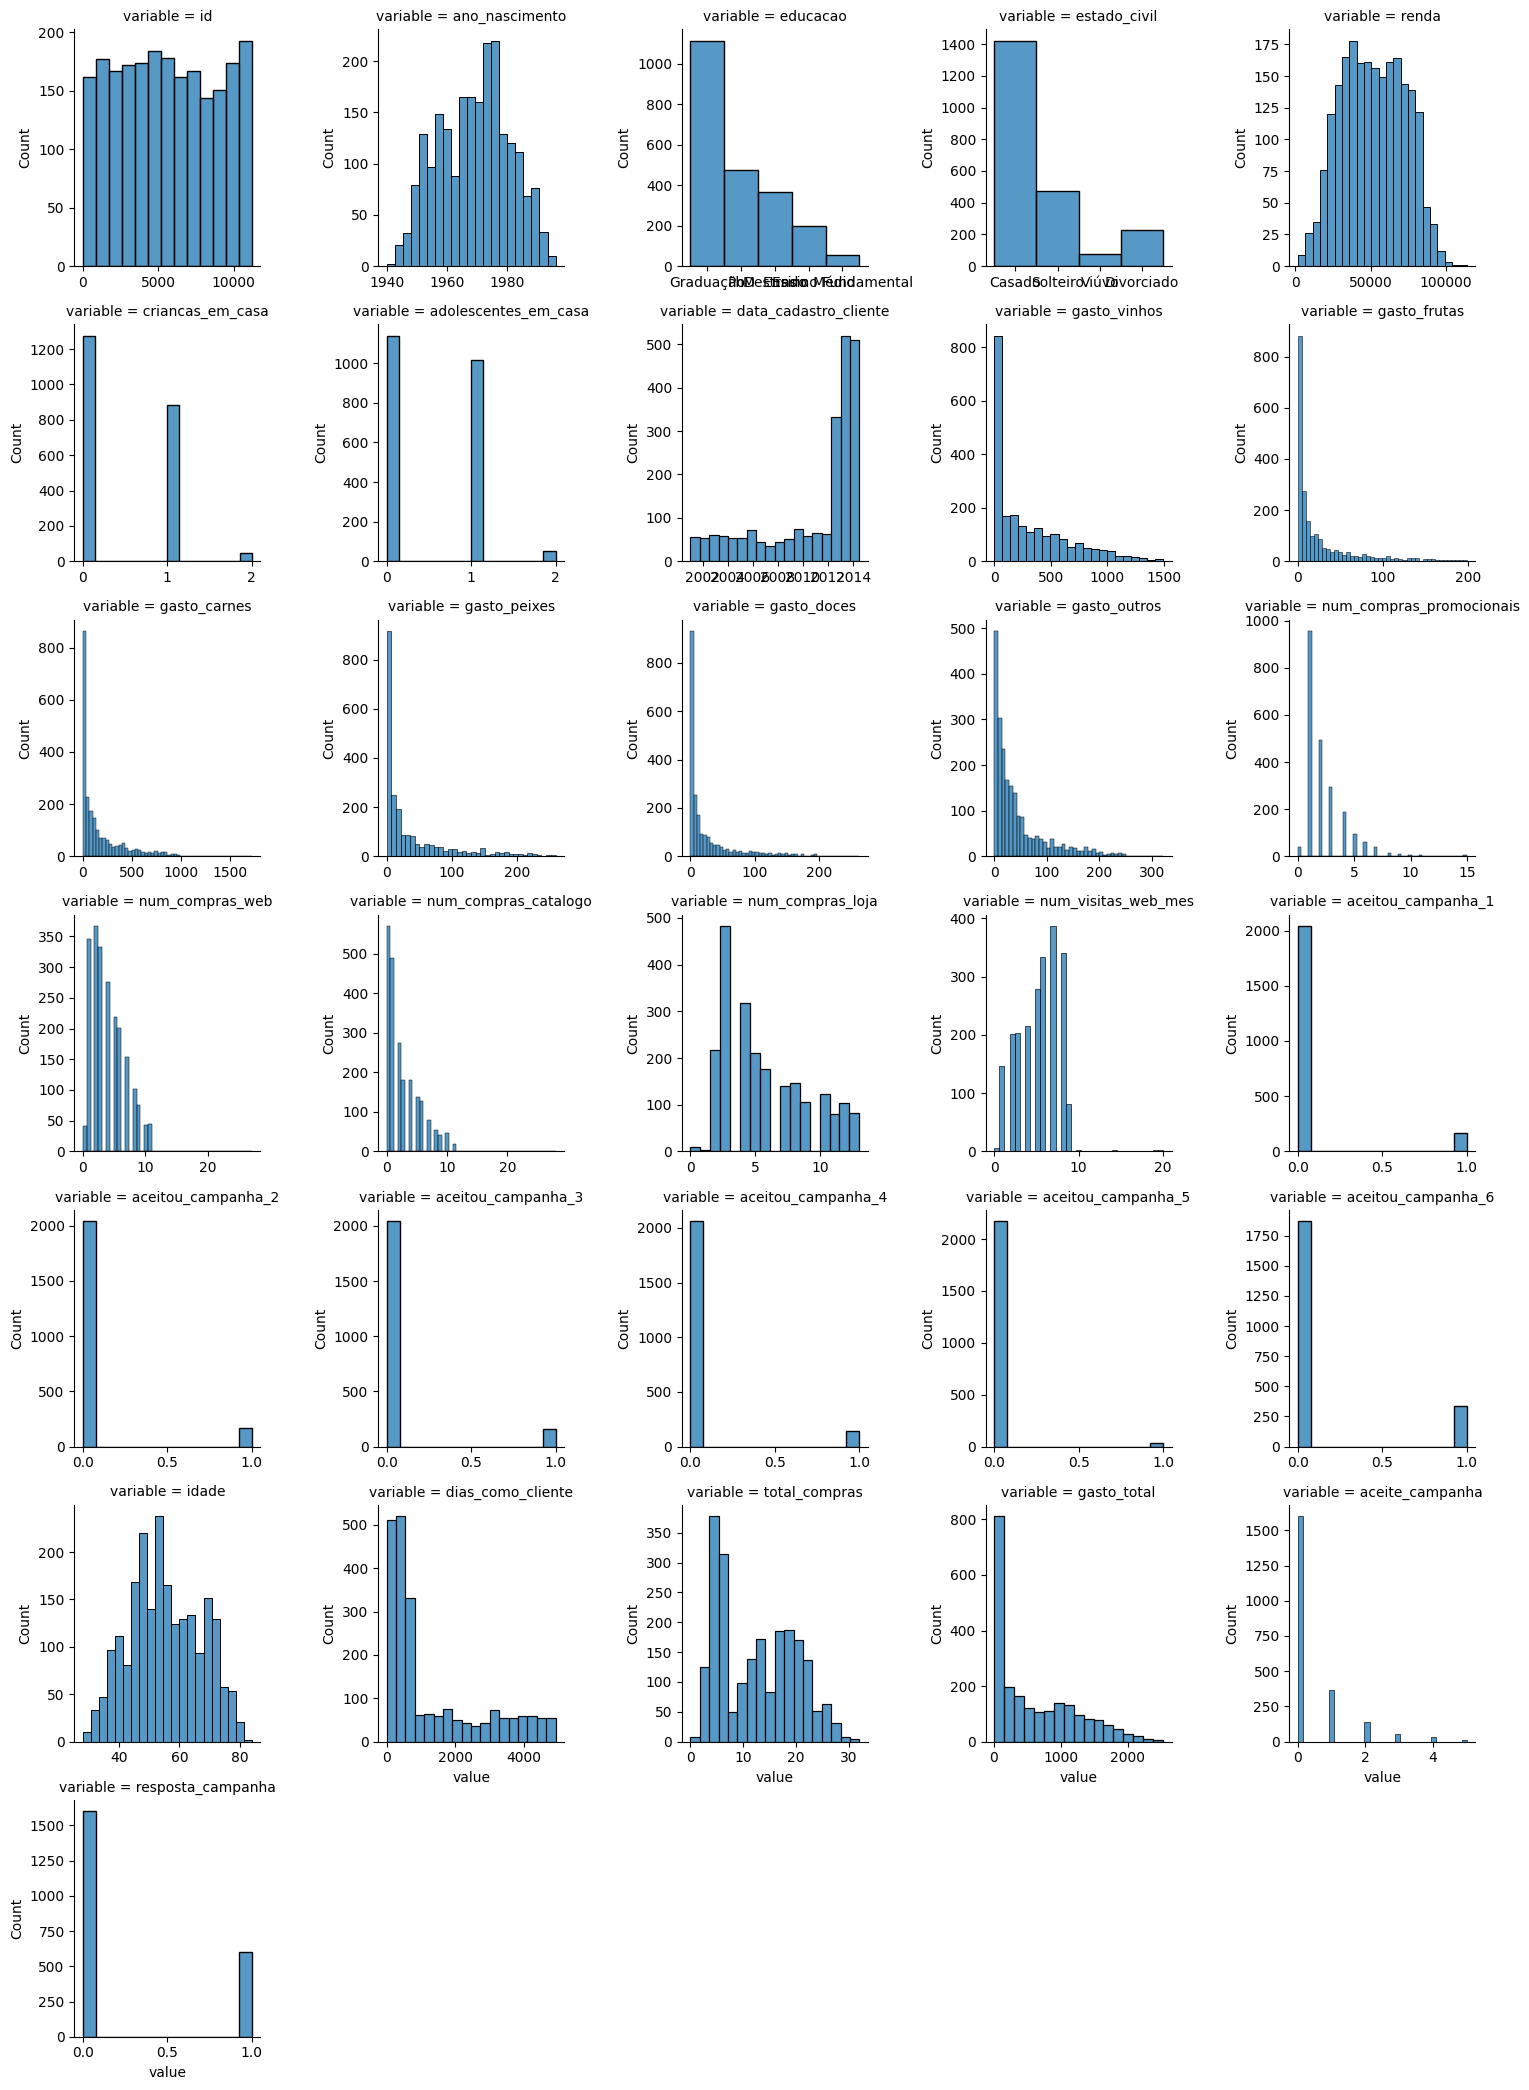

In [79]:
df_plot = df_no_outliers.melt()
plot = sns.FacetGrid(df_plot, col='variable', col_wrap= 5, sharex= False, sharey= False)
plot.map(sns.histplot, 'value')

# Extraindo Insights dos Dados 

## Qual a Proporção de Clientes que aceitaram e que Aceitaram Campanha de Marketing?

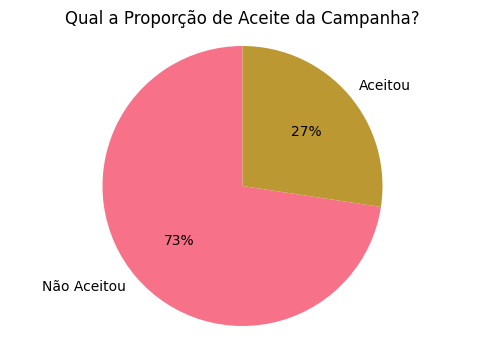

In [80]:
fig, ax = plt.subplots(figsize = (6,4))

counts = df_no_outliers['resposta_campanha'].value_counts().rename(index = {1:'Aceitou', 0: 'Não Aceitou'})
labels = counts.index.tolist()

# cores
colors = sns.color_palette('husl')

# plot
ax.pie(counts, labels = labels, colors = colors, autopct = '%0.0f%%', startangle = 90)

ax.axis('equal')

ax.set_title('Qual a Proporção de Aceite da Campanha?')

plt.show()

## Qual o Percentual de Aceite de cada Campanha?

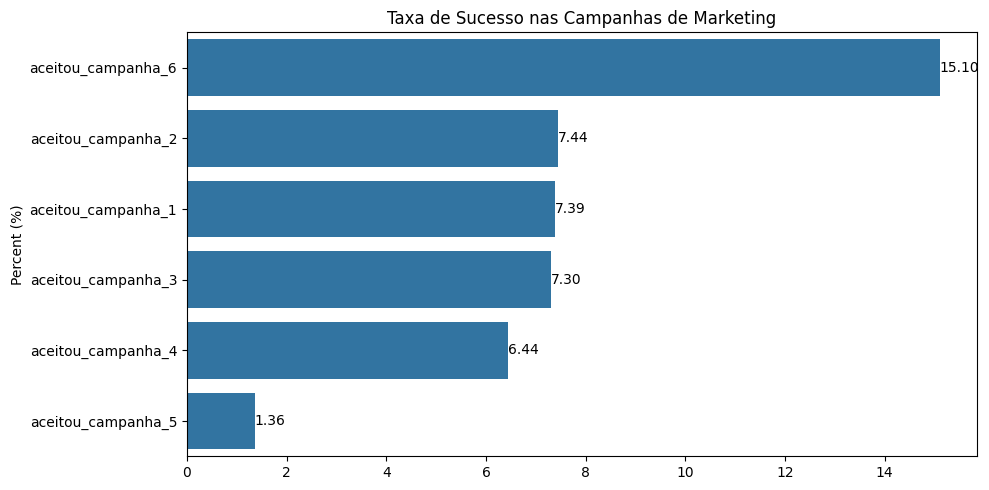

In [81]:
campanhas = (df_no_outliers.filter(like='aceitou_campanha').mean() * 100).to_frame('percent').reset_index()

fig, ax = plt.subplots(figsize = (10,5))
sns.barplot(data= campanhas.sort_values('percent',ascending = False),
            y = 'index', 
            x = 'percent', ax = ax)

ax.set_ylabel('Percent (%)')
ax.set_xlabel(None)
plt.bar_label(ax.containers[0],fmt='%.2f')
plt.title('Taxa de Sucesso nas Campanhas de Marketing')
plt.tight_layout()
plt.show()

## A idade influencia nos gastos dos clientes?

In [82]:
df_no_outliers.corr(numeric_only=True).filter(like = 'gasto').loc['idade',:]

gasto_vinhos    0.164438
gasto_frutas    0.013149
gasto_carnes    0.041540
gasto_peixes    0.040855
gasto_doces     0.021075
gasto_outros    0.059295
gasto_total     0.118404
Name: idade, dtype: float64

A influência da Idade nos gastos é muito baixa

## Qual a relação entre o Gasto total e a Resposta às Campanhas de Marketing?

Text(0.5, 1.0, 'Gasto Total x Resposta Campanhas')

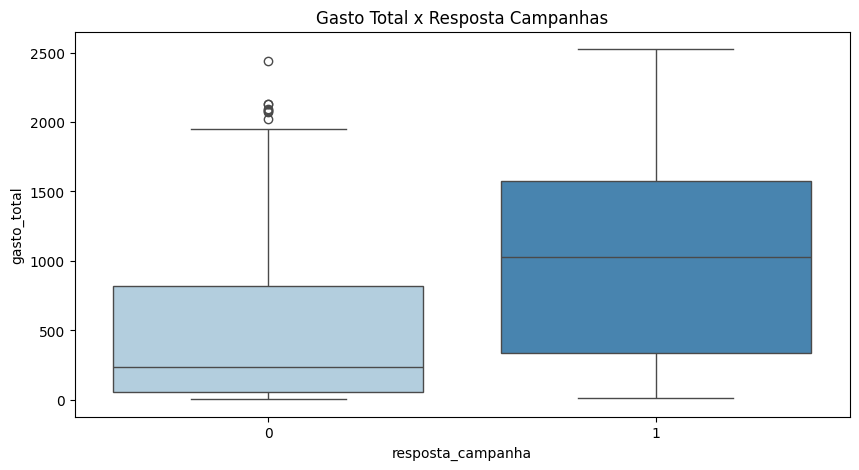

In [83]:
plt.figure(figsize = (10,5))
sns.boxplot(data = df_no_outliers, x = 'resposta_campanha', y = 'gasto_total', palette = 'Blues')
plt.title('Gasto Total x Resposta Campanhas')

## Qual categoria de Produtos teve o maior gasto?

In [84]:
cols_gastos = df_no_outliers.filter(like='gasto').drop('gasto_total',axis=1).columns
df_plot = df_no_outliers[cols_gastos].sum().to_frame('total_gastos').reset_index()
df_plot

,index,total_gastos
0,gasto_vinhos,675093
1,gasto_frutas,58219
2,gasto_carnes,364513
3,gasto_peixes,83253
4,gasto_doces,59818
5,gasto_outros,97146


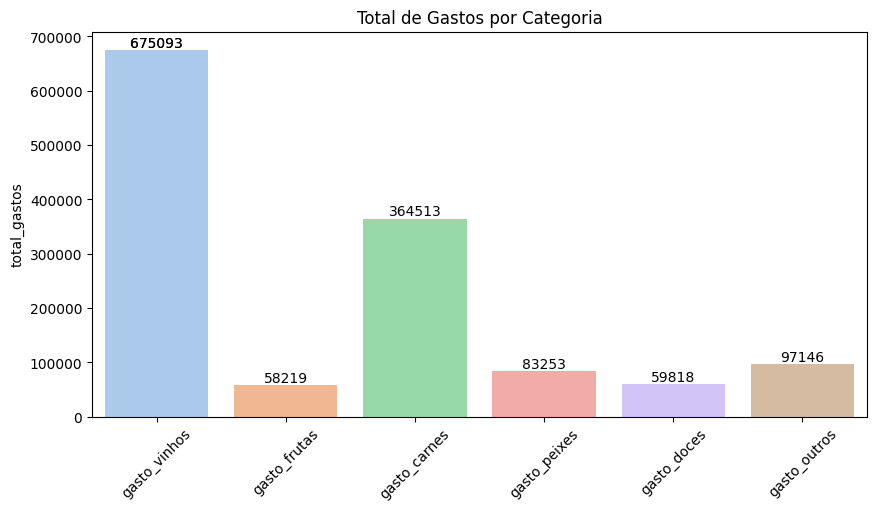

In [85]:
fig, ax = plt.subplots(figsize = (10,5))
sns.barplot(data = df_plot, x = 'index', y = 'total_gastos', ax = ax, palette='pastel')
for i in range(df_plot.shape[0]): 
    plt.bar_label(ax.containers[i])
plt.xticks(rotation = 45)
plt.bar_label(ax.containers[0])
plt.xlabel(None)
plt.title('Total de Gastos por Categoria')
plt.show()



## Qual a relação entre a Resposta às Campanhas e o Gasto total?

Text(0.5, 1.0, 'Gasto Total x Resposta a Campanhas')

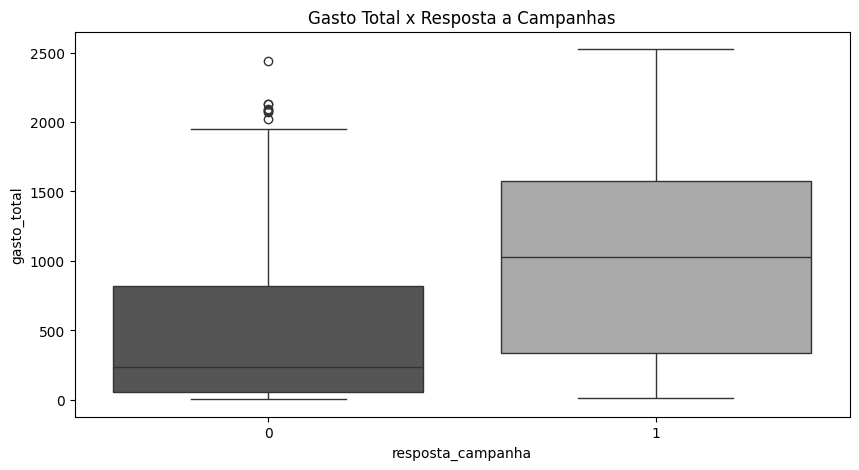

In [86]:
plt.figure(figsize=(10,5))
sns.boxplot(data= df_no_outliers, x = 'resposta_campanha', y = 'gasto_total', palette='gray')
plt.title('Gasto Total x Resposta a Campanhas')

## Qual a relação entre o Gasto Total e a Renda?

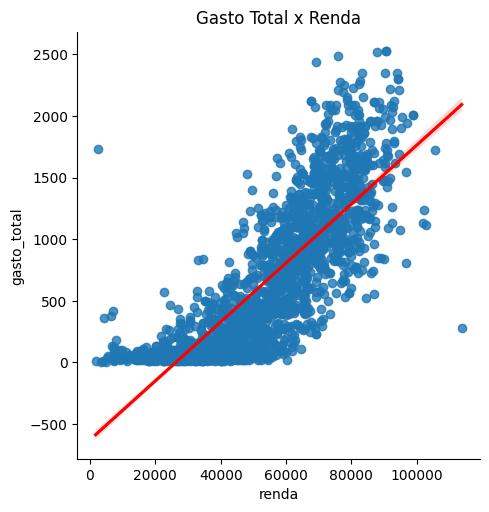

In [87]:
sns.lmplot(data= df_no_outliers, x = 'renda', y = 'gasto_total', line_kws = {'color':'red'})
plt.title('Gasto Total x Renda')
plt.show()

# Quais são as Variáveis que mais impactam nas Respostas às Campanhas?

In [88]:
# Pegando as colunas categoricas
cat_cols = df_no_outliers.select_dtypes('object').columns

In [89]:
# Transformando os dados categoricos em Dummies
df_transformed = pd.get_dummies(data= df_no_outliers, columns= cat_cols)

In [90]:
# Dropando colunas com informação redundante
cols_to_drop = df_transformed.filter(regex = '(gasto)|(aceitou_campanha)').columns.tolist()
cols_to_drop.remove('gasto_total')
df_transformed.drop(columns= cols_to_drop + 
                    ['id','data_cadastro_cliente','ano_nascimento','num_compras_web',
                    'num_compras_catalogo','num_compras_loja','aceite_campanha'],
 inplace = True)

In [91]:
# Separando Target e Preditoras
X = df_transformed.drop(columns=['resposta_campanha'])
y = df_transformed['resposta_campanha']

In [109]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [124]:
X

,renda,criancas_em_casa,adolescentes_em_casa,num_compras_promocionais,num_visitas_web_mes,idade,dias_como_cliente,total_compras,gasto_total,educacao_Ensino Fundamental,educacao_Ensino Médio,educacao_Graduação,educacao_Mestrado,educacao_PhD,estado_civil_Casado,estado_civil_Divorciado,estado_civil_Solteiro,estado_civil_Viúvo
0,55375.0,0,1,1,2,47,255,8,162,False,False,True,False,False,True,False,False,False
1,77037.0,0,1,1,3,64,259,26,1123,False,False,False,False,True,True,False,False,False
2,24163.0,1,1,2,4,54,1294,4,17,False,False,True,False,False,False,False,True,False
3,69476.0,0,0,1,2,55,272,14,1044,False,False,False,False,True,True,False,False,False
4,72063.0,0,1,2,2,45,2665,19,758,False,False,True,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2232,40344.0,0,1,2,7,50,259,10,218,False,False,False,False,True,True,False,False,False
2233,57867.0,1,0,7,6,46,1628,18,612,False,False,True,False,False,True,False,False,False
2234,25410.0,1,0,1,4,51,302,5,38,False,False,True,False,False,True,False,False,False
2235,13260.0,1,1,4,8,54,310,6,49,False,False,True,False,False,True,False,False,False


In [125]:
import statsmodels.api as sm

X_with_constant = sm.add_constant(X_scaled)
X_model = pd.DataFrame(X_with_constant, columns= ['constant'] + scaler.get_feature_names_out().tolist(), index = X.index)
model = sm.Logit(y, X_model).fit()

Optimization terminated successfully.
         Current function value: 0.485443
         Iterations 8


In [126]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:      resposta_campanha   No. Observations:                 2205
Model:                          Logit   Df Residuals:                     2188
Method:                           MLE   Df Model:                           16
Date:                Fri, 27 Sep 2024   Pseudo R-squ.:                  0.1732
Time:                        00:39:17   Log-Likelihood:                -1070.4
converged:                       True   LL-Null:                       -1294.6
Covariance Type:            nonrobust   LLR p-value:                 2.491e-85
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
constant                       -1.1755      0.057    -20.567      0.000      -1.287      -1.063
renda                           0.5707      0.134      4.263      0.000       0.308       0.833
criancas_em_casa                0.0012      0.080      0.015      0.988      -0.155       0.157
adolescentes_em_casa           -0.3394      0.072     -4.741      0.000      -0.480      -0.199
num_compras_promocionais        0.0254      0.068      0.374      0.709      -0.108       0.158
num_visitas_web_mes             0.6619      0.083      7.962      0.000       0.499       0.825
idade                           0.0679      0.059      1.147      0.252      -0.048       0.184
dias_como_cliente               0.0199      0.054      0.368      0.713      -0.086       0.126
total_compras                  -0.2633      0.106     -2.491      0.013      -0.471      -0.056
gasto_total                     0.9511      0.115      8.279      0.000       0.726       1.176
educacao_Ensino Fundamental    -0.0055   1.52e+06  -3.62e-09      1.000   -2.98e+06    2.98e+06
educacao_Ensino Médio          -0.0313   2.81e+06  -1.11e-08      1.000   -5.51e+06    5.51e+06
educacao_Graduação             -0.0352   4.91e+06  -7.16e-09      1.000   -9.63e+06    9.63e+06
educacao_Mestrado              -0.0106   3.65e+06  -2.92e-09      1.000   -7.15e+06    7.15e+06
educacao_PhD                    0.0762   4.04e+06   1.89e-08      1.000   -7.92e+06    7.92e+06
estado_civil_Casado            -0.0761        nan        nan        nan         nan         nan
estado_civil_Divorciado         0.0203        nan        nan        nan         nan         nan
estado_civil_Solteiro           0.0565        nan        nan        nan         nan         nan
estado_civil_Viúvo              0.0380        nan        nan        nan         nan         nan
===============================================================================================
"""

In [142]:
model.pvalues.sort_values(ascending=True).map(lambda x: str(x).format('%.0'))

constant                        5.431056489891854e-94
gasto_total                    1.2433846465271978e-16
num_visitas_web_mes             1.692741108559583e-15
adolescentes_em_casa           2.1280571185487995e-06
renda                          2.0153914886733983e-05
total_compras                     0.01274634202920507
idade                             0.25152396577692293
num_compras_promocionais            0.708610110150625
dias_como_cliente                  0.7132370169615929
criancas_em_casa                   0.9879541232267419
educacao_PhD                       0.9999999849593619
educacao_Ensino Médio              0.9999999911041872
educacao_Graduação                 0.9999999942835228
educacao_Ensino Fundamental         0.999999997108128
educacao_Mestrado                  0.9999999976724835
estado_civil_Casado                               nan
estado_civil_Divorciado                           nan
estado_civil_Solteiro                             nan
estado_civil_Viúvo          

In [92]:
# Treianndo o Random Forest
model = RandomForestClassifier(random_state=42)
model.fit(X, y)

RandomForestClassifier(random_state=42)

In [93]:
# Extraindo importancias do Modelo
importances = model.feature_importances_

In [94]:
# Indices ordenados
indices = np.argsort(importances)

In [95]:
df_importances = pd.DataFrame({'variaveis':model.feature_names_in_, 'importancias': importances})\
    .sort_values('importancias', ascending = False)

Text(0.5, 1.0, 'Importância das Variáveis')

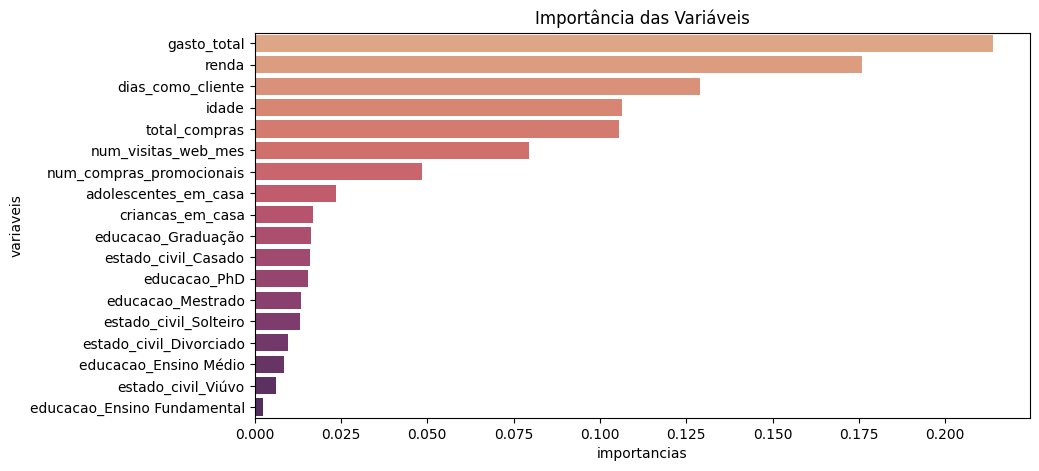

In [96]:
plt.figure(figsize = (10,5))
sns.barplot(data = df_importances, x = 'importancias' ,y = 'variaveis' ,palette = 'flare')
plt.title('Importância das Variáveis')

# Teste de Hipóteses

O Nível Educacional não foi muito relevante para as respostas às campanhas de marketing. No entanto, a renda foi bem relevante, é provável que a média da renda seja diferente entre os níveis educacionais.

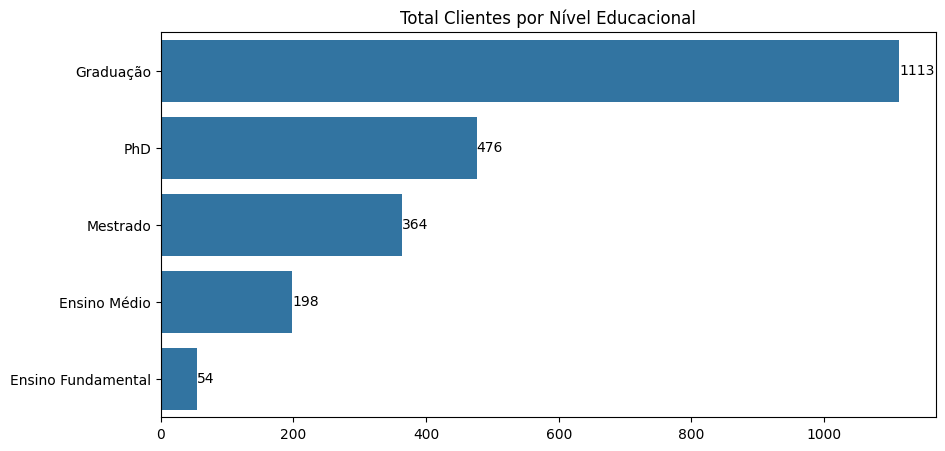

In [97]:
df_plot = df_no_outliers.groupby('educacao').agg(count = ('id', 'count')).reset_index()

plt.figure(figsize = (10,5))
ax = sns.barplot(data = df_plot.sort_values('count', ascending=False), y = 'educacao', x ='count')
plt.bar_label(ax.containers[0])
plt.title('Total Clientes por Nível Educacional')
plt.ylabel(None)
plt.xlabel(None)
#plt.xticks(rotation = 45)
plt.show()

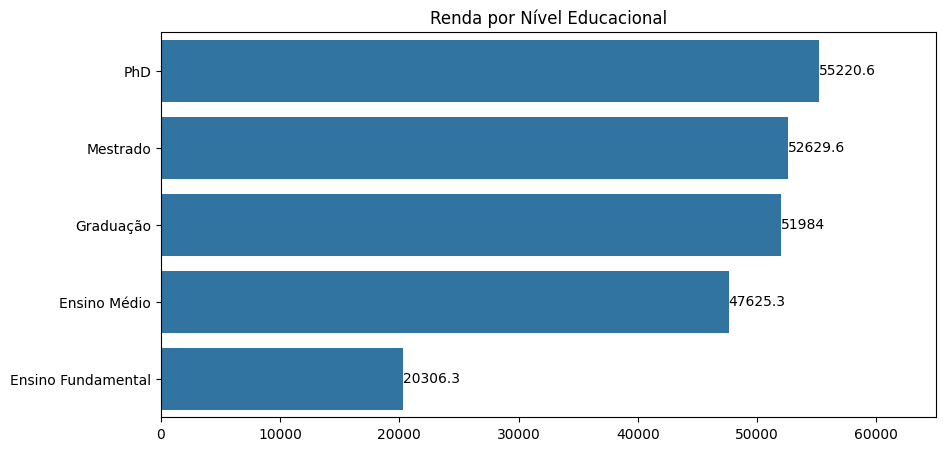

In [98]:
df_plot = df_no_outliers.groupby('educacao').agg(renda_media = ('renda', 'mean')).reset_index()

plt.figure(figsize = (10,5))
ax = sns.barplot(data = df_plot.sort_values('renda_media', ascending=False), y = 'educacao', x ='renda_media')
plt.bar_label(ax.containers[0])
plt.title('Renda por Nível Educacional')
plt.ylabel(None)
plt.xlabel(None)
plt.xlim(0,65000)
plt.show()

## Definindo as Hipóteses

H0 = Não há evidências suficientes para apoiar a diferença das médias entre os grupos com ensino superior e sem ensino superior    
Ha = Existe uma diferença estatísticamente significativa entre das médias dos grupos

Para realizar o teste T de Student precisamos validar algumas suposições e uma delas é a normalidade

## Teste Shapiro Wilk

H0 = Não temos evidêcias suficientes para apoiar a hipótese de que a distribuição não é normal     
H1 = Temos evidências suficientes para apoiar a hipótese que a distribuição não é normal

In [99]:
encode = {
    'Graduação':3, 
    'PhD':5,
    'Mestrado':4,
    'Ensino Médio':2,
    'Ensino Fundamental':1
}
df_no_outliers['educacao'] = df_no_outliers['educacao'].map(encode)

Text(0.5, 1.0, 'Distribuição da Educação')

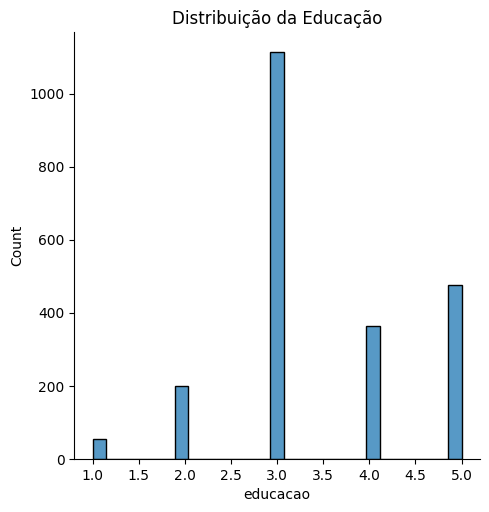

In [100]:
sns.displot(df_no_outliers['educacao'])
plt.title("Distribuição da Educação")

Text(0.5, 1.0, 'Distribuição da Renda')

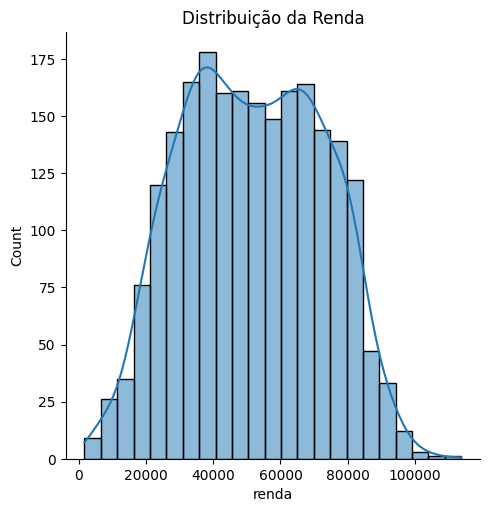

In [101]:
sns.displot(df_no_outliers['renda'], kde = True)
plt.title("Distribuição da Renda")

In [102]:
from scipy.stats import shapiro

stat_educacao, p_value_educacao = shapiro(df_no_outliers['educacao'])
stat_renda, p_value_renda = shapiro(df_no_outliers['renda'])

# Teste educacao

alpha = 0.05
if p_value_educacao < alpha:
    print(f'Educação: Temos evidências suficientes para rejeitar a hipótese nula e apoiar a hipótese de que a os dados não seguem uma distribuição Normal')
else:
    print(f'Educação: Não temos evidências suficientes para rejeitar a hipótese nula')


if p_value_renda < alpha:
    print(f'Renda: Temos evidências suficientes para rejeitar a hipótese nula e apoiar a hipótese de que a os dados não seguem uma distribuição Normal')
else:
    print(f'Renda: Não temos evidências suficientes para rejeitar a hipótese nula')

Educação: Temos evidências suficientes para rejeitar a hipótese nula e apoiar a hipótese de que a os dados não seguem uma distribuição Normal
Renda: Temos evidências suficientes para rejeitar a hipótese nula e apoiar a hipótese de que a os dados não seguem uma distribuição Normal


Concluimos que as variáveis não seguem uma distribuição normal. Logo, teremos que utilizar um teste não paramétrico.

## Teste não paramétrico - Mann - Whitney U

In [104]:
# Criando os grupos para o teste

grupo_com_graduacao = df_no_outliers.query("educacao in (5,4,3)")['renda']
grupo_sem_graduacao = df_no_outliers.query("educacao in (1, 2)")['renda']

In [105]:
# Teste Mann Whitney U
from scipy.stats import mannwhitneyu

stat_u, p_value = mannwhitneyu(grupo_com_graduacao, grupo_sem_graduacao)

if p_value < alpha:
    print(f'Temos evidências suficientes para rejeitar H0. Portanto, existe uma diferença significativa entre a média dos grupos')
else:
    print(f'Não temos evidências suficientes para rejeitar H0. Portanto, Não existe uma diferença significativa entre a média dos grupos')

Temos evidências suficientes para rejeitar H0. Portanto, existe uma diferença significativa entre a média dos grupos


# Conclusão

OS fatores mais relevantes que explicam a resposta dos clientes as campanhas de marketing são:

- Historico de Gasto total
- Renda
- Tempo total como Cliente
- Idade
- Total de compras Anteriores

As demais variáveis não parecem ser tão relevantes para explicar a resposta dos clientes ás campanhas.    
Ao testar a hipótese de que clientes com graduação tinham renda média maior que clientes sem graduação. Vimos que de fato existe uma diferença significativa entre a renda desses grupos.    
Logo, através desse estudo recomendamos que as campanhas sejam criadas de forma segmentada baseada nas variáveis mais relevantes e no nível educacional dos clientes.